This notebook is an outsample test we got for vdisc dataset. Generally, it got about 65% acc. :(

# Import Data

In [15]:
import tensorflow
import keras
import numpy as np
np.random.seed(1248)

In [16]:
import pandas as pd

In [17]:
data = pd.read_csv('../data/vdisc_train_buffer_over_data_small.csv.gz')

In [18]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['filename']
del labels['code']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [20]:
x = pd.read_csv("../data/vdisc_embedding.csv")
x['testcase_ID'] = x['type']
del x['type']
x = x.sort_values("testcase_ID")

In [21]:
y = labels['buffer']

In [22]:
testcase_IDs = x['testcase_ID']
x = x.drop('testcase_ID', axis='columns')

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# [Neural tutorial](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)

In [47]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam

In [48]:
model = Sequential()

model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total para

In [50]:
!pip install pydot

You should consider upgrading via the 'pip install --upgrade pip' command.


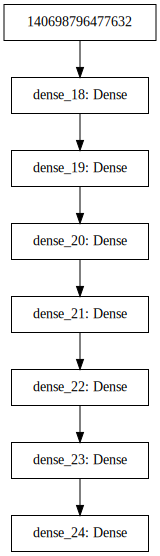

In [51]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return model_to_dot(model).create(prog='dot', format='svg')

model_diagram = visualize_model(model)

with open('../images/graph2vec-architecture-dnn.svg', 'wb') as f:
    f.write(model_diagram)

SVG(model_diagram)

In [52]:
model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
22982/22982 [==============================] - 1s 61us/step - loss: 0.6323 - acc: 0.6318
Epoch 2/50
22982/22982 [==============================] - 1s 42us/step - loss: 0.6182 - acc: 0.6442
Epoch 3/50
22982/22982 [==============================] - 1s 41us/step - loss: 0.6154 - acc: 0.6461
Epoch 4/50
22982/22982 [==============================] - 1s 42us/step - loss: 0.6157 - acc: 0.6475
Epoch 5/50
22982/22982 [==============================] - 1s 43us/step - loss: 0.6139 - acc: 0.6480
Epoch 6/50
22982/22982 [==============================] - 1s 44us/step - loss: 0.6113 - acc: 0.6495
Epoch 7/50
22982/22982 [==============================] - 1s 43us/step - loss: 0.6110 - acc: 0.6486
Epoch 8/50
22982/22982 [==============================] - 1s 42us/step - loss: 0.6103 - acc: 0.6517
Epoch 9/50
22982/22982 [==============================] - 1s 43us/step - loss: 0.6085 - acc: 0.6509
Epoch 10/50
22982/22982 [==============================] - 1s 43us/step - loss: 0.6075 - acc: 0.6522

In [29]:
import pickle

In [30]:
with open('../data/dense-model-binary','wb') as f:
    pickle.dump(model,f)

In [53]:
model.evaluate(x_test,y_test)

5746/5746 [==============================] - 0s 61us/step


[0.6773556792233989, 0.6510616081581687]

In [33]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [55]:
y_predict= model.predict(x_test)

In [56]:
import numpy as np

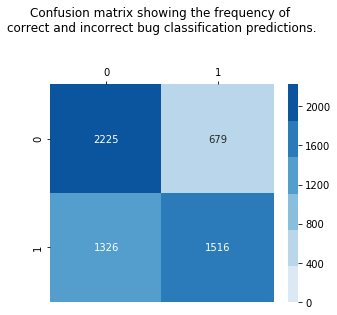

In [57]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 4)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

confusion_figure.savefig('../images/baseline_conf_matrix')

In [58]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict)).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [59]:
fpr_nn

0.30933940774487473

In [60]:
fnr_nn

0.3734159391720642

In [66]:
from sklearn.metrics import roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve((y_test.values+0), y_predict)
precision, recall, thresholds = precision_recall_curve((y_test.values+0), y_predict)

In [67]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score((y_test.values+0), y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score((y_test.values+0), np.rint(y_predict))
mcc = matthews_corrcoef((y_test.values+0), np.rint(y_predict))

In [68]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.704
ROC AUC: 0.711
MCC: 0.308
F1: 0.602


In [69]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

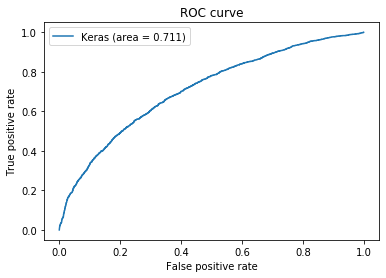

<Figure size 432x288 with 0 Axes>

In [70]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('../images/baseline_roc_curve')

### Train / Test / Validation Split

### Fitting Model with 3-way Split for Validation

In [24]:
with open('../data/x-train-binary-for-3-way-split','rb') as f:
    x_train1 = pickle.load(f)
    
with open('../data/y-train-binary-for-3-way-split','rb') as f:
    y_train1 = pickle.load(f)
    
with open('../data/x-val-binary','rb') as f:
    x_val = pickle.load(f)
    
with open('../data/y-val-binary','rb') as f:
    y_val = pickle.load(f)

In [72]:
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=50, batch_size=64)

NameError: name 'x_val' is not defined

In [26]:
model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 68us/step


[0.08080741595255998, 0.9544292025110439]

In [27]:
y_predict1= model.predict(x_test)

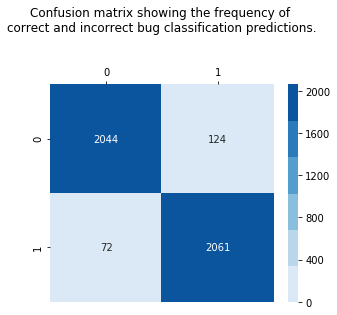

In [28]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict1)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 4)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [32]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict1)).flatten().tolist()

fpr_nn1 = fp/(fp+tp)
fnr_nn1 = fn/(fn+tn)

In [33]:
fpr_nn1

0.056750572082379866

In [34]:
fnr_nn1

0.034026465028355386